In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import py_scripts.db_fcns as db
import py_scripts.data_fcns as fcns

## Mukavia funktioita

In [2]:
def get_timetables(alkuasema, loppuasema, dates):
    timetables = pd.DataFrame()
    for date in dates:
        new_table = fcns.get_train_nums(alkuasema, loppuasema, str(date.date()))
        if new_table is None:
            continue
        new_table["departureDate"] = str(date.date())
        timetables = pd.concat([timetables, new_table])
    return timetables

In [3]:
def dist_dict(train_num, date, d, c):
    return {"trainNumber": train_num, 
            "departureDate": date, 
            "dist_from_speed": d, 
            "dist_from_coords": c
           }


def get_data(uniques):
    df = pd.DataFrame()
    distances = pd.DataFrame()

    for num, date in uniques:
        try:
            new_df = fcns.get_train_location_data(num, date, False)
        except KeyError as e:
            print(f"{type(e).__name__}: {e} [{date=}, {num=}]")
            continue
        if new_df is None:
            continue
            
        alku = new_df[new_df["station"] == alkuasema]
        if len(alku) > 0:
            index1 = alku.index.max()
        else:
            continue
        loppu = new_df[new_df["station"] == loppuasema]
        if len(loppu) > 0:
            index2 = loppu.index.min()
        else:
            continue
        dist_from_speed = new_df.loc[index2, "dist_from_speed"] - new_df.loc[index1, "dist_from_speed"]
        dist_from_coords = new_df.loc[index2, "dist_from_coords"] - new_df.loc[index1, "dist_from_coords"]
        distances = pd.concat([distances, pd.DataFrame([dist_dict(num, date, dist_from_speed, dist_from_coords)])])

        new_df = new_df.loc[index1:index2, :]
        new_df["dist_from_speed"] = new_df["dist_from_speed"] - new_df["dist_from_speed"].min()
        new_df["dist_from_coords"] = new_df["dist_from_coords"] - new_df["dist_from_coords"].min()
        df = pd.concat([df, new_df])
        
        # onko nukkuminen tarpeen?
        time.sleep(0.3)
        
    return [df, distances]

In [4]:
def get_distances_from_df(df):
    groups = df.groupby(["trainNumber", "departureDate"])
    dist_from_coords = groups["dist_from_coords"].max() - groups["dist_from_coords"].min()
    dist_from_speed = groups["dist_from_speed"].max() - groups["dist_from_speed"].min()
    result = pd.concat([dist_from_speed, dist_from_coords], axis=1)
    return result.reset_index()

## Haetaan dataa

In [5]:
df = None
distances = None

use_db = True

if use_db:
    df = db.get_df_from_db("jamsa_orivesi", from_extra=True)
    distances = db.get_df_from_db("jamsa_orivesi_distance", from_extra=True)

if df is not None and distances is None:
    distances = get_distances_from_df(df)

if df is None:
    alkuasema = "JÄS"
    loppuasema = "OV"
    dates = pd.date_range("2023-01-01", periods=2, freq="1D")
    # dates = pd.date_range("2022-04-01", "2022-09-30", freq="1D")
    
    timetables = get_timetables(alkuasema, loppuasema, dates)
    uniques = uniques = timetables.apply(lambda r: (r["trainNumber"], r["departureDate"]), axis=1).unique()
    df, distances = get_data(uniques)

probably table {table_name} does not exist


In [6]:
# pitääkäö seivata?
save_to_db = False

if save_to_db:
    db.save_df_to_db(df, "jamsa_orivesi", to_extra=True)

## Katsotaan mitä data sisältää

In [7]:
# 42766 entries, 13 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161180 entries, 0 to 161179
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   trainNumber         161180 non-null  int64              
 1   departureDate       161180 non-null  object             
 2   timestamp           161180 non-null  datetime64[ns, UTC]
 3   speed               161180 non-null  int64              
 4   duration            161180 non-null  float64            
 5   latitude            161180 non-null  float64            
 6   longitude           161180 non-null  float64            
 7   acceleration        161180 non-null  float64            
 8   change_of_location  161180 non-null  float64            
 9   dist_from_coords    161180 non-null  float64            
 10  dist_from_speed     161180 non-null  float64            
 11  stops_from_speed    161180 non-null  int64              
 12  station         

In [8]:
# 212 entries, 4 columns
distances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trainNumber       1305 non-null   int64  
 1   departureDate     1305 non-null   object 
 2   dist_from_speed   1305 non-null   float64
 3   dist_from_coords  1305 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 40.9+ KB


In [9]:
distances.loc[:, ["dist_from_speed", "dist_from_coords"]].describe()

,dist_from_speed,dist_from_coords
count,1305.000000,1305.000000
mean,55878.060026,56699.175514
std,954.979897,9089.027928
min,40549.166667,51220.111309
25%,55786.111111,55438.758124
50%,55901.388889,55528.163342
75%,56000.833333,55735.921545
max,62320.555556,356808.125073


In [10]:
# mean / median

# koko tammikuu
# based on speed
# 55.75 km / 55.90 km
# based on coords
# 55.25 km / 55.61 km

# 2 ekaa päivää
# based on speed
# 55.97 km / 55.91 km
# based on coords
# 55.34 km / 55.55 km

### Paras arvio etäisyydestä 100 metrin tarkkuudella

In [11]:
# voisi toki käyttää mediaania keskiarvon sijaan
best_dist = round(distances["dist_from_speed"].mean(), -2)
best_dist

55900.0

In [12]:
# distances.reset_index(drop=True, inplace=True)

# trains = []
# for i in distances.index:
#     trains.append((distances.loc[i, "trainNumber"], distances.loc[i, "departureDate"]))

In [13]:
trains = list(distances.value_counts(["trainNumber", "departureDate"]).index)

In [14]:
len(trains)

1305

In [15]:
# trains[0]

### Pudotetaan turhat muuttujat pois

In [16]:
main_df = df.loc[:, ["trainNumber", "departureDate", "dist_from_speed", "acceleration"]].copy()
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161180 entries, 0 to 161179
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trainNumber      161180 non-null  int64  
 1   departureDate    161180 non-null  object 
 2   dist_from_speed  161180 non-null  float64
 3   acceleration     161180 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ MB


In [17]:
main_df.reset_index(drop=True, inplace=True)

### Skaalataan kuljettu matka

In [18]:
def scale_distance(row, ref_df, best_dist):
    # max_dist = df[(df["trainNumber"] == row["trainNumber"]) & (df["departureDate"] == row["departureDate"])]["dist_from_speed"].max()
    max_dist = ref_df[(row["trainNumber"], row["departureDate"])]
    return row["dist_from_speed"] * best_dist / max_dist

In [19]:
max_d = main_df.groupby(["trainNumber", "departureDate"])["dist_from_speed"].max()
main_df["dist_from_speed"] = main_df.apply(lambda r: scale_distance(r, max_d, best_dist), axis=1)

In [20]:
# for num, date in trains:
#     d = main_df[(main_df["trainNumber"] == num) & (main_df["departureDate"] == date)]["dist_from_speed"]
#     i1 = d.index.min()
#     i2 = d.index.max()
#     main_df.loc[i1:i2, "dist_from_speed"] = d * best_dist / d.max()

In [21]:
# voi olla turha
def peculiar_rounding(num, reference=best_dist):
    res = round(num)
    if res == reference:
        return reference
    return num

In [22]:
# pyöristys varmistaa, että perillä etäisyys on aina sama
main_df["dist_from_speed"] = main_df["dist_from_speed"].apply(peculiar_rounding)

### Lisätään etäisyyden checkpointit dataan (100 m välein)

In [23]:
step_length = 100
checkpoints = np.arange(0, best_dist + 1, step_length)

In [24]:
def accel_dict(num, date, dist, accel=None):
    return {"trainNumber": num,
            "departureDate": date,
            "dist_from_speed": dist,
            "acceleration": accel
           }

In [25]:
additions = []
for num, date in trains:
    for d in checkpoints[1:-1]:
        additions.append(accel_dict(num, date, d))

In [26]:
main_df = pd.concat([main_df, pd.DataFrame(additions)])

In [27]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889370 entries, 0 to 728189
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trainNumber      889370 non-null  int64  
 1   departureDate    889370 non-null  object 
 2   dist_from_speed  889370 non-null  float64
 3   acceleration     161180 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 33.9+ MB


### Täytetään checkpointtien kiihtyvyysarvot

In [28]:
main_df = main_df.sort_values(["departureDate", "trainNumber", "dist_from_speed"])

In [29]:
main_df = main_df.fillna(method="bfill")

In [30]:
main_df.head(20)

,trainNumber,departureDate,dist_from_speed,acceleration
507,86,2022-04-01,0.000000,0.000000
508,86,2022-04-01,0.000000,0.277778
509,86,2022-04-01,62.419974,0.388889
527310,86,2022-04-01,100.000000,0.407407
527311,86,2022-04-01,200.000000,0.407407
510,86,2022-04-01,212.227913,0.407407
527312,86,2022-04-01,300.000000,0.296296
527313,86,2022-04-01,400.000000,0.296296
511,86,2022-04-01,453.585147,0.296296
527314,86,2022-04-01,500.000000,0.074074


## Tarkastellaan vain checkpointteja

In [31]:
testi = main_df[main_df["dist_from_speed"].isin(checkpoints)].copy()

In [32]:
len(testi)

732105

In [33]:
# jyrkkä ei kopioille
testi.drop_duplicates(["departureDate", "trainNumber", "dist_from_speed"], inplace=True)

In [34]:
len(testi)

730800

In [35]:
# for num, date in trains:
#     if len(testi[(testi["trainNumber"] == num) & (testi["departureDate"] == date)]) != len(checkpoints):
#         print(num, date)

In [36]:
testi.reset_index(drop=True, inplace=True)

In [37]:
testi["acceleration+"] = testi["acceleration"].apply(lambda a: max(a, 0))
testi["acceleration_abs"] = testi["acceleration"].apply(abs)

In [38]:
testi.head()

,trainNumber,departureDate,dist_from_speed,acceleration,acceleration+,acceleration_abs
0,86,2022-04-01,0.0,0.000000,0.000000,0.000000
1,86,2022-04-01,100.0,0.407407,0.407407,0.407407
2,86,2022-04-01,200.0,0.407407,0.407407,0.407407
3,86,2022-04-01,300.0,0.296296,0.296296,0.296296
4,86,2022-04-01,400.0,0.296296,0.296296,0.296296


### Muunnetaan DF klusterointiin soveltuvaan muotoon

In [39]:
# MUISTA

# pd.pivot_table(testi, values="acceleration", index=["departureDate", "trainNumber"], columns=["dist_from_speed"], aggfunc=np.mean)

In [40]:
def get_cluster_df(df, col_name="acceleration"):
    result = pd.pivot_table(df, values=col_name, index=["departureDate", "trainNumber"], columns=["dist_from_speed"], aggfunc=np.mean)
    return result.dropna()

In [41]:
clustering_df = get_cluster_df(testi)

In [42]:
# clustering_df.dropna(inplace=True)

In [43]:
# vanha tapa
def get_clustering_df(nums_and_dates, df, clustering_columns, col_name="acceleration"):
    clustering_df = pd.DataFrame(columns=clustering_columns)
    
    for num, date in nums_and_dates:
        partial_df = fcns.get_locations_for_train(num, date, df)
        i1 = partial_df.index.min()
        i2 = partial_df.index.max()
        accel = df.loc[i1:i2, col_name].copy().to_numpy()
        clustering_df = pd.concat([clustering_df, pd.DataFrame([accel], columns=clustering_columns)])
        
    clustering_df.index = nums_and_dates
    
    return clustering_df

In [44]:
# clustering_df.insert(0, "mean_accel", clustering_df.mean(axis=1))

In [45]:
# clustering_results = testi.groupby(["departureDate", "trainNumber"]).mean()

In [46]:
# clustering_results["cluster_id"] = km.predict(clustering_df.drop(["mean_accel", "cluster_id"], axis=1))

In [47]:
# clustering_results.head(10)

### KMeans kehiin

In [48]:
# km = KMeans(n_clusters=15, n_init="auto", max_iter=1337, random_state=4096)
km = KMeans(n_clusters=25, n_init="auto")
if "cluster_id" in clustering_df.columns:
    clustering_df.drop("cluster_id", axis=1, inplace=True)
km.fit(clustering_df)

if "cluster_id" in clustering_df.columns:
    clustering_df.drop("cluster_id", axis=1, inplace=True)
# clustering_df.insert(0, "cluster_id", km.predict(clustering_df))

clustering_results = testi.groupby(["departureDate", "trainNumber"]).mean()
clustering_results["cluster_id"] = km.predict(clustering_df)

In [49]:
def get_clusters(clustering_results):
    clusters = clustering_results.groupby("cluster_id")

    table = pd.concat([clusters["acceleration_abs"].count(), clusters["acceleration_abs"].min(), clusters["acceleration_abs"].max(), clusters["acceleration_abs"].mean()], axis=1)
    table.columns=["count", "min mean abs accel", "max mean abs accel", "mean mean abs accel"]
    return table.sort_values("count", ascending=False)

In [50]:
#clusters = clustering_results.groupby("cluster_id")

#table = pd.concat([clusters["acceleration_abs"].count(), clusters["acceleration_abs"].min(), clusters["acceleration_abs"].max(), clusters["acceleration_abs"].mean()], axis=1)
#table.columns=["count", "min mean abs accel", "max mean abs accel", "mean mean abs accel"]
#clustering_res = table.sort_values("count", ascending=False)
#clustering_res.head()

In [51]:
clustering_res = get_clusters(clustering_results)
clustering_res.head()

,count,min mean abs accel,max mean abs accel,mean mean abs accel
cluster_id,,,,
9,351,0.026125,0.126762,0.058249
19,284,0.045915,0.131092,0.069043
8,211,0.046299,0.146278,0.071431
6,179,0.044509,0.162174,0.071581
4,167,0.019866,0.112290,0.059064


In [52]:
# clustering_results.head(10)

In [53]:
# clustering_df.head()

In [54]:
def run_kmeans(df_to_cluster, k):
    km = KMeans(n_clusters=k, n_init="auto")
    km.fit(df_to_cluster)
    cluster_ids = km_pos.predict(cluster_df_pos)
    return [km, cluster_ids]

In [55]:
# cluster_df_pos = get_clustering_df(trains, testi, checkpoints, "acceleration+")
cluster_df_pos = get_cluster_df(testi, "acceleration+")

In [56]:
len(cluster_df_pos)

1305

In [57]:
km_pos = KMeans(n_clusters=25, n_init="auto")

if "mean_accel+" in cluster_df_pos.columns:
    cluster_df_pos.drop("mean_accel+", axis=1, inplace=True)
if "cluster_id" in cluster_df_pos.columns:
    cluster_df_pos.drop("cluster_id", axis=1, inplace=True)
km_pos.fit(cluster_df_pos)
cluster_ids = km_pos.predict(cluster_df_pos)

cluster_df_pos.insert(0, "mean_accel+", cluster_df_pos.mean(axis=1))
cluster_df_pos.insert(0, "cluster_id", cluster_ids)

In [58]:
clusters_pos = cluster_df_pos.groupby("cluster_id")

table = pd.concat([clusters_pos["mean_accel+"].count(), clusters_pos["mean_accel+"].min(), clusters_pos["mean_accel+"].max()], axis=1)
table.columns=["count", "min mean accel+", "max mean accel+"]
c_counts = table.sort_values("count", ascending=False)
c_counts.head(8)

,count,min mean accel+,max mean accel+
cluster_id,,,
3,282,0.005400,0.049326
1,230,0.018237,0.046213
20,214,0.014170,0.052947
9,201,0.017164,0.048775
7,142,0.020345,0.051038
2,107,0.025385,0.072779
24,55,0.022117,0.069226
19,28,0.025412,0.052001


In [59]:
# cluster_df_pos.iloc[:6, :6]

In [60]:
def print_stuff(cluster_id):
    a = clustering_df[clustering_df["cluster_id"] == cluster_id]
    # print(a.iloc[0, :2])
    
    plt.plot(a.iloc[0, :])
    plt.grid()
    plt.show()
    print()
    

In [61]:
# for i in table.index:
    # if table.loc[i, "count"] == 1:
        # print_stuff(i)

In [62]:
clustering_results.head()

dist_from_speed  acceleration  acceleration+  \
departureDate trainNumber                                                 
2022-04-01    86                   27950.0     -0.003095       0.020451   
              88                   27950.0     -0.004472       0.022419   
              94                   27950.0     -0.004702       0.030857   
              140                  27950.0     -0.003398       0.037506   
              142                  27950.0     -0.005155       0.026133   

                           acceleration_abs  cluster_id  
departureDate trainNumber                                
2022-04-01    86                   0.043997           9  
              88                   0.049311           4  
              94                   0.066417           4  
              140                  0.078410           8  
              142                  0.057420          19

In [63]:
c_df_res = clustering_results.loc[:, ["cluster_id", "acceleration"]]
c_df = clustering_df
# c_df_res = cluster_df_pos.loc[:, ["cluster_id", "mean_accel+"]]
# c_df = cluster_df_pos.drop(["cluster_id", "mean_accel+"], axis=1)

In [64]:
default_lower_bound = max(30, 0.05 * len(clustering_df))
# default_lower_bound = 0.1 * len(cluster_df_pos)

def get_replacements(cluster_counts, lower_bound=default_lower_bound):
    clusters = cluster_counts[cluster_counts > lower_bound]
    return {c: i for i, c in enumerate(clusters.index)}

In [65]:
get_replacements(clustering_res["count"])
# get_replacements(c_counts["count"])

{9: 0, 19: 1, 8: 2, 6: 3, 4: 4}

In [66]:
c_df_res.groupby("cluster_id").count().sort_values("acceleration", ascending=False).head()
# c_df_res.groupby("cluster_id").count().sort_values("mean_accel+", ascending=False).head()

,acceleration
cluster_id,
9,351
19,284
8,211
6,179
4,167


In [67]:
def replacement_fcn(num, cluster_counts):
    replacements = get_replacements(cluster_counts)
    # replacements = {22: 0, 19: 1, 23: 2, 17: 3, 24: 4}
    if replacements.get(num) is None:
        return len(replacements)
    return replacements[num]

In [68]:
c_df_res["cluster_id"] = c_df_res["cluster_id"].apply(lambda n: replacement_fcn(n, clustering_res["count"]))
# c_df_res["cluster_id"] = c_df_res["cluster_id"].apply(lambda n: replacement_fcn(n, c_counts["count"]))

In [69]:
c_df_res.groupby("cluster_id").count().sort_values("acceleration", ascending=False)
# c_df_res.groupby("cluster_id").count().sort_values("mean_accel+", ascending=False)

,acceleration
cluster_id,
0,351
1,284
2,211
3,179
4,167
5,113


In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(c_df, c_df_res["cluster_id"].to_numpy(), test_size=0.2)

In [71]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

In [72]:
accuracy_score(Y_test, Y_pred)

0.5440613026819924

In [73]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.45      0.96      0.61        72
           1       0.62      0.51      0.56        51
           2       0.62      0.24      0.35        41
           3       0.50      0.19      0.27        32
           4       0.79      0.56      0.66        34
           5       1.00      0.39      0.56        31

    accuracy                           0.54       261
   macro avg       0.66      0.47      0.50       261
weighted avg       0.63      0.54      0.52       261



In [74]:
# clustering_df["cluster_id"].value_counts()

In [75]:
clustering_df.insert(0, "cluster_id", clustering_results["cluster_id"])
k = clustering_df.groupby("cluster_id").mean()
k.insert(0, "count", clustering_df["cluster_id"].value_counts())
k = k.sort_values("count", ascending=False)
clustering_df.drop("cluster_id", axis=1, inplace=True)

In [76]:
# k.insert(0, "count", clustering_df["cluster_id"].value_counts())

In [77]:
a = k.iloc[:, 1:]

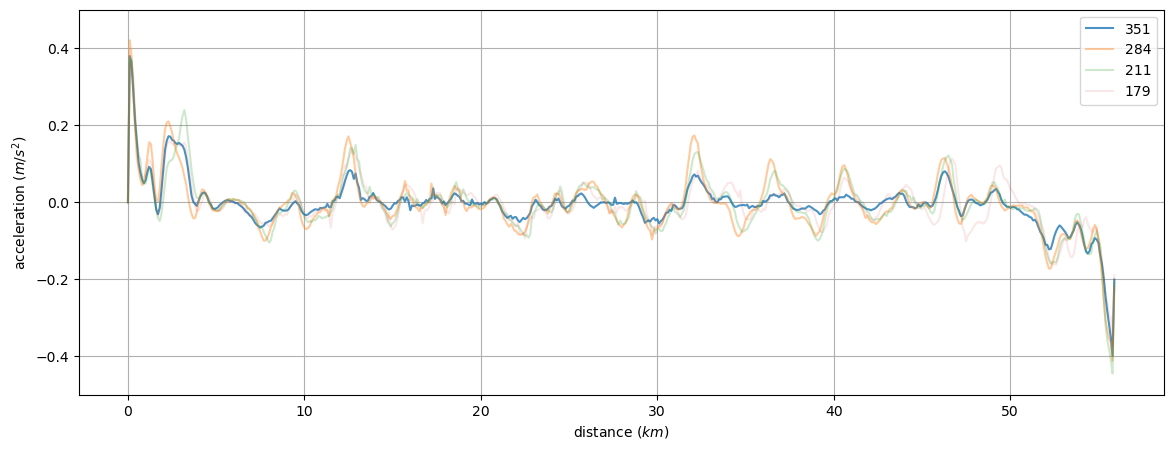

18.41317128350665
26.4990973770489
26.553504949253742
24.98606223416776


In [78]:
fig, ax = plt.subplots(figsize=(14, 5))
abs_mean = []
n = 4
decrease = 0
for i in a.index[:n]:
    # ax.plot(a.columns[1:] / 1000, a.loc[i, 100.0:])
    ax.plot(a.columns / 1000, a.loc[i, :], alpha=0.8 - 0.4 * np.sqrt(decrease))
    decrease += 1
    
    abs_mean.append(a.loc[i, :].apply(abs).sum())

# ax.set_title(f"Accelerations of train {train_num} during {str(dates[0].date())} - {str(dates[-1].date())}")
ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend(k["count"].head(n))
ax.grid()
plt.show()

for m in abs_mean:
    print(m)

In [79]:
abs_mean[0] / abs_mean[1]

0.6948603200143133

In [80]:
km.cluster_centers_.shape

(25, 560)

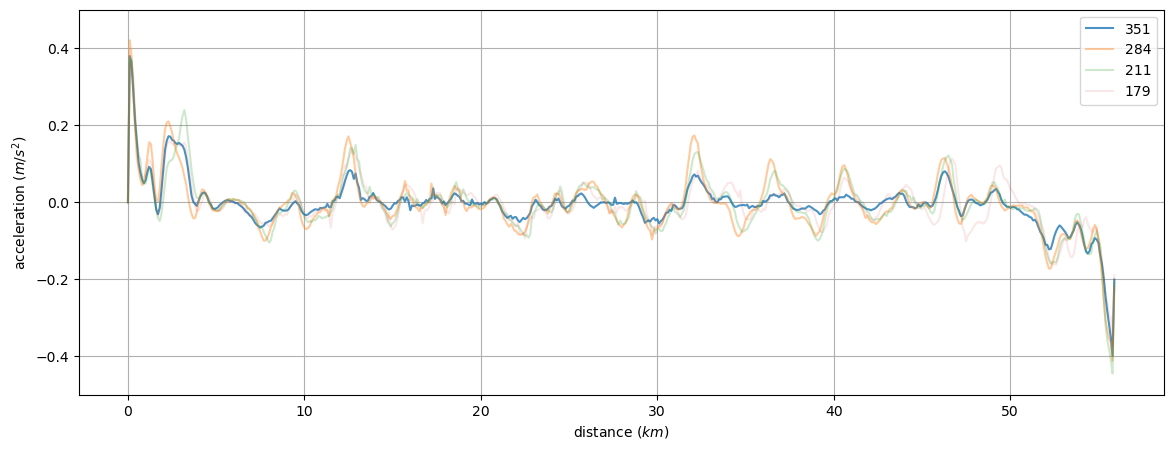

18.41317128350665
26.4990973770489
26.55350494925375
24.98606223416776


0.6948603200143133

In [81]:
fig, ax = plt.subplots(figsize=(14, 5))
abs_mean = []
n = 4
decrease = 0
for i in a.index[:n]:
    # ax.plot(checkpoints / 1000, km.cluster_centers_[i, :])
    ax.plot(a.columns / 1000, a.loc[i, :], alpha=0.8 - 0.4 * np.sqrt(decrease))
    decrease += 1
    
    abs_mean.append(abs(km.cluster_centers_[i, :]).sum())

# ax.set_title(f"Accelerations of train {train_num} during {str(dates[0].date())} - {str(dates[-1].date())}")
ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend(k["count"].head(n))
ax.grid()
plt.show()

for m in abs_mean:
    print(m)

abs_mean[0] / abs_mean[1]